In [1]:
from googleapiclient.discovery import build
import sys
import pandas as pd
from IPython.display import JSON

# data visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

In [2]:
# Youtube API Key
api_key = 'XXXXX'

In [3]:
channel_ids = ['UC14UlmYlSNiQCBe9Eookf_A']

In [4]:
api_service_name = "youtube"
api_version = "v3"

# Get credentials and create an API client
youtube = build(
    api_service_name, api_version, developerKey=api_key)

In [5]:
def get_channel_stats(youtube, channel_ids):
    """
    Get channel statistics

    Params:
    youtube: build object from Youtube API
    channel_ids: list of Youtube channel IDs.

    Returns: 
    A DataFrame containing the channel stats for each channel ID.
    """
    
    all_data = []
    
    request = youtube.channels().list(
        part="snippet,contentDetails,statistics",
        id=','.join(channel_ids)
    )
    response = request.execute()
    
    # Loop through items
    for item in response['items']:
        data = {
            'channelName': item['snippet']['title'],
            'subscribers': item['statistics']['subscriberCount'],
            'views': item['statistics']['viewCount'],
            'totalVideos': item['statistics']['videoCount'],
            'playlistId': item['contentDetails']['relatedPlaylists']['uploads']
        }
        all_data.append(data)
    return pd.DataFrame(all_data)


def get_video_ids(youtube, playlist_id):
    """
    Get all video IDs from the YouTube playlist.

    Params:
    youtube: build object from Youtube API.
    playlist_id: The ID of the YouTube playlist from which to retrieve video IDs.

    Returns: 
    A list of video IDs.
    """
    
    video_ids = []
    
    request = youtube.playlistItems().list(
        part="snippet,contentDetails",
        playlistId=playlist_id,
        maxResults=50
    )
    response = request.execute()
    
    for item in response['items']:
        video_ids.append(item['contentDetails']['videoId'])
        
    next_page_token = response.get('nextPageToken')
    while next_page_token is not None:
        request = youtube.playlistItems().list(
            part='contentDetails',
            playlistId=playlist_id,
            maxResults=50,
            pageToken=next_page_token
        )
        response = request.execute()
        
        for item in response['items']:
            video_ids.append(item['contentDetails']['videoId'])
        
        next_page_token = response.get('nextPageToken')
        
    return video_ids


def get_video_details(youtube, video_ids):
    """
    Retrieve details for a list of YouTube videos.

    Params:
    youtube: build object from Youtube API
    video_ids: A list of video IDs for which to retrieve details.

    Returns: 
    A DataFrame containing video details.
    """
    
    all_video_info = []

    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute()
        
        for video in response['items']:
            stats_to_keep = {
                'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                'contentDetails': ['duration', 'definition', 'caption']
            }
            video_info = {}
            video_info['video_id'] = video['id']
        
            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except KeyError:
                        video_info[v] = None
        
            all_video_info.append(video_info)
    
    return pd.DataFrame(all_video_info)

In [6]:
channel_stats = get_channel_stats(youtube, channel_ids)

In [7]:
channel_stats

,channelName,subscribers,views,totalVideos,playlistId
0,FC Barcelona,18000000,3659685070,12245,UU14UlmYlSNiQCBe9Eookf_A


In [8]:
playlist_id = "UU14UlmYlSNiQCBe9Eookf_A"

In [9]:
# Get video IDs
video_ids = get_video_ids(youtube, playlist_id)

In [10]:
len(video_ids)

12225

In [11]:
# Get video details
video_df = get_video_details(youtube, video_ids)
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
0,OGlVAJtGiPU,FC Barcelona,This kid is good! #LaLigaHighlights,,None,2024-08-27T15:06:00Z,4011,1943,None,66,PT12S,hd,false
1,lFx8uPmSaPs,FC Barcelona,🔴 BARÇA LIVE | RAYO VALLECANO VS FC BARCELONA ...,Join us LIVE for Barça vs Rayo match.\n\nSUBSC...,"[FC Barcelona, برشلونة،, Fútbol, FUTBOL, socce...",2024-08-27T10:54:42Z,0,398,None,0,P0D,sd,false
2,p_3HLez_j7s,FC Barcelona,International Dog Day 🐶🫶 #fcbarcelona #shorts,SUBSCRIBE NOW:\n▶ www.youtube.com/user/fcbarce...,"[FC Barcelona, برشلونة،, Fútbol, FUTBOL, socce...",2024-08-26T13:31:23Z,158152,21046,None,183,PT19S,hd,false
3,v-hEKEG6wlA,FC Barcelona,🔥 MATCH PREVIEW: RAYO vs FC BARCELONA 🔥 | LA LIGA,Every available first team player trains on th...,"[FC Barcelona, برشلونة،, Fútbol, FUTBOL, socce...",2024-08-26T13:27:09Z,195626,15892,None,470,PT6M17S,hd,false
4,gKkhih4aM4g,FC Barcelona,FULL MATCH | FC BARCELONA vs AC MILAN | GAMPER...,A packed Estadi Johan Cruyff got to enjoy the ...,"[FC Barcelona, برشلونة،, Fútbol, FUTBOL, socce...",2024-08-25T18:30:57Z,50060,2671,None,121,PT1H56M36S,hd,false
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12220,Q1gyZ2uUq4U,FC Barcelona,Deco: un guanyador des de la infància (I),Deco: un guanyador des de la infància,"[Programa, Deco, Barça, tv, online]",2007-06-06T15:16:04Z,13808,248,None,None,PT1M37S,sd,false
12221,YqUGWOvdUhI,FC Barcelona,Messi dedica el golazo del Barça - Getafe a Ma...,Messi dedica el golazo del Barça - Getafe a Ma...,"[messi, maradona, fcbarcelona, getafe, golazo,...",2007-04-19T18:05:28Z,111139,5957,None,None,PT1M40S,sd,false
12222,4wAofNMDdBU,FC Barcelona,"Messi, el crack más joven","Messi, el crack más joven","[messi, fcbarcelona]",2007-04-19T10:25:31Z,212413,4161,None,None,PT36S,sd,false
12223,S8Ne1P7W_4U,FC Barcelona,"""Me siento útil para el técnico y la plantilla""","En el último partido de Brasil ante Chile, Ron...","[edmilson, fcbarcelona]",2007-04-02T12:02:23Z,18277,654,None,None,PT2M10S,sd,false


### Data Pre-Processing ###

In [12]:
#check for empty values
video_df.isnull().any()

video_id          False
channelTitle      False
title             False
description       False
tags               True
publishedAt       False
viewCount         False
likeCount          True
favouriteCount     True
commentCount       True
duration          False
definition        False
caption           False
dtype: bool

In [13]:
# check data types
video_df.dtypes

video_id          object
channelTitle      object
title             object
description       object
tags              object
publishedAt       object
viewCount         object
likeCount         object
favouriteCount    object
commentCount      object
duration          object
definition        object
caption           object
dtype: object

In [14]:
# Convert count columns to numeric
numeric_cols = ['viewCount', 'likeCount', 'favouriteCount', 'commentCount']
video_df[numeric_cols] = video_df[numeric_cols].apply(pd.to_numeric, errors = 'coerce', axis = 1)

In [15]:
# Create a Publish day in the week
from dateutil import parser

video_df['publishedAt'] = video_df['publishedAt'].apply(lambda x: parser.parse(x))
video_df['publishDayName'] = video_df['publishedAt'].apply(lambda x: x.strftime("%A"))

In [16]:
# convert duration to seconds
import isodate
video_df['durationSecs'] = video_df['duration'].apply(lambda x: isodate.parse_duration(x))
video_df['durationSecs'] = video_df['durationSecs'].apply(lambda x: x.total_seconds())

In [17]:
video_df[['durationSecs', 'duration']]

,durationSecs,duration
0,12.0,PT12S
1,0.0,P0D
2,19.0,PT19S
3,377.0,PT6M17S
4,6996.0,PT1H56M36S
...,...,...
12220,97.0,PT1M37S
12221,100.0,PT1M40S
12222,36.0,PT36S
12223,130.0,PT2M10S


In [18]:
# add tag count
video_df['tagCount'] = video_df['tags'].apply(lambda x: 0 if x is None else len(x))

In [19]:
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,publishDayName,durationSecs,tagCount
0,OGlVAJtGiPU,FC Barcelona,This kid is good! #LaLigaHighlights,,None,2024-08-27 15:06:00+00:00,4011.0,1943.0,NaN,66.0,PT12S,hd,false,Tuesday,12.0,0
1,lFx8uPmSaPs,FC Barcelona,🔴 BARÇA LIVE | RAYO VALLECANO VS FC BARCELONA ...,Join us LIVE for Barça vs Rayo match.\n\nSUBSC...,"[FC Barcelona, برشلونة،, Fútbol, FUTBOL, socce...",2024-08-27 10:54:42+00:00,0.0,398.0,NaN,0.0,P0D,sd,false,Tuesday,0.0,51
2,p_3HLez_j7s,FC Barcelona,International Dog Day 🐶🫶 #fcbarcelona #shorts,SUBSCRIBE NOW:\n▶ www.youtube.com/user/fcbarce...,"[FC Barcelona, برشلونة،, Fútbol, FUTBOL, socce...",2024-08-26 13:31:23+00:00,158152.0,21046.0,NaN,183.0,PT19S,hd,false,Monday,19.0,46
3,v-hEKEG6wlA,FC Barcelona,🔥 MATCH PREVIEW: RAYO vs FC BARCELONA 🔥 | LA LIGA,Every available first team player trains on th...,"[FC Barcelona, برشلونة،, Fútbol, FUTBOL, socce...",2024-08-26 13:27:09+00:00,195626.0,15892.0,NaN,470.0,PT6M17S,hd,false,Monday,377.0,46
4,gKkhih4aM4g,FC Barcelona,FULL MATCH | FC BARCELONA vs AC MILAN | GAMPER...,A packed Estadi Johan Cruyff got to enjoy the ...,"[FC Barcelona, برشلونة،, Fútbol, FUTBOL, socce...",2024-08-25 18:30:57+00:00,50060.0,2671.0,NaN,121.0,PT1H56M36S,hd,false,Sunday,6996.0,46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12220,Q1gyZ2uUq4U,FC Barcelona,Deco: un guanyador des de la infància (I),Deco: un guanyador des de la infància,"[Programa, Deco, Barça, tv, online]",2007-06-06 15:16:04+00:00,13808.0,248.0,NaN,NaN,PT1M37S,sd,false,Wednesday,97.0,5
12221,YqUGWOvdUhI,FC Barcelona,Messi dedica el golazo del Barça - Getafe a Ma...,Messi dedica el golazo del Barça - Getafe a Ma...,"[messi, maradona, fcbarcelona, getafe, golazo,...",2007-04-19 18:05:28+00:00,111139.0,5957.0,NaN,NaN,PT1M40S,sd,false,Thursday,100.0,13
12222,4wAofNMDdBU,FC Barcelona,"Messi, el crack más joven","Messi, el crack más joven","[messi, fcbarcelona]",2007-04-19 10:25:31+00:00,212413.0,4161.0,NaN,NaN,PT36S,sd,false,Thursday,36.0,2
12223,S8Ne1P7W_4U,FC Barcelona,"""Me siento útil para el técnico y la plantilla""","En el último partido de Brasil ante Chile, Ron...","[edmilson, fcbarcelona]",2007-04-02 12:02:23+00:00,18277.0,654.0,NaN,NaN,PT2M10S,sd,false,Monday,130.0,2


###EDA ###

#### Best Performing Videos ####

/var/folders/_p/7shlyhpn0wjdbyl0890x45_w0000gn/T/ipykernel_25013/898968552.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 129316 (\N{DROOLING FACE}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 128153 (\N{BLUE HEART}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/events.p

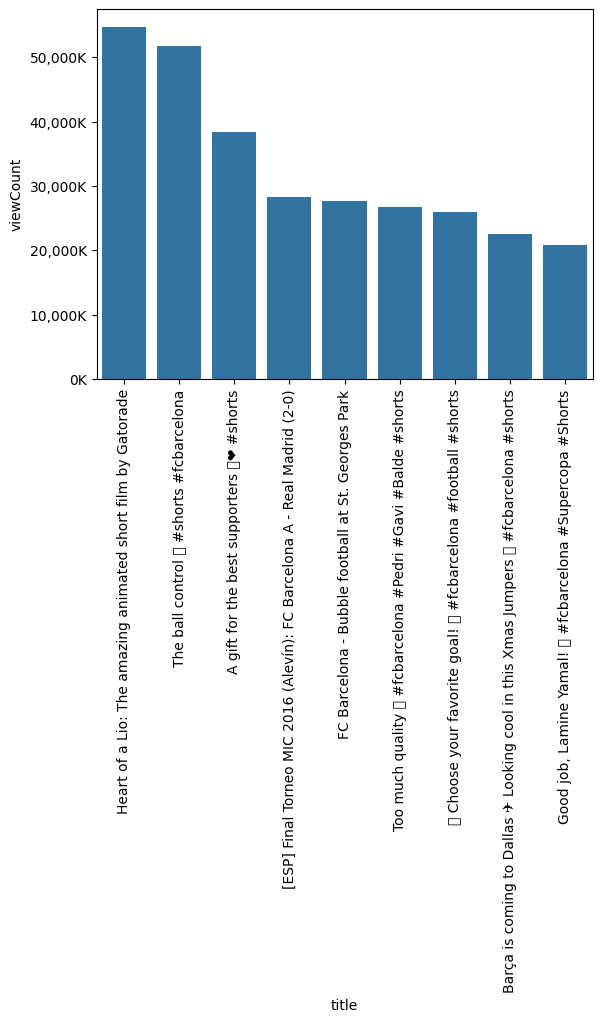

In [20]:
#create a bar plot for best videos
ax = sns.barplot(x = 'title', y = 'viewCount', data = video_df.sort_values('viewCount', ascending = False) [0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

### Worst Performing Videos ###

/var/folders/_p/7shlyhpn0wjdbyl0890x45_w0000gn/T/ipykernel_25013/427183976.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 9917 (\N{SOCCER BALL}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 127918 (\N{VIDEO GAME}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/events

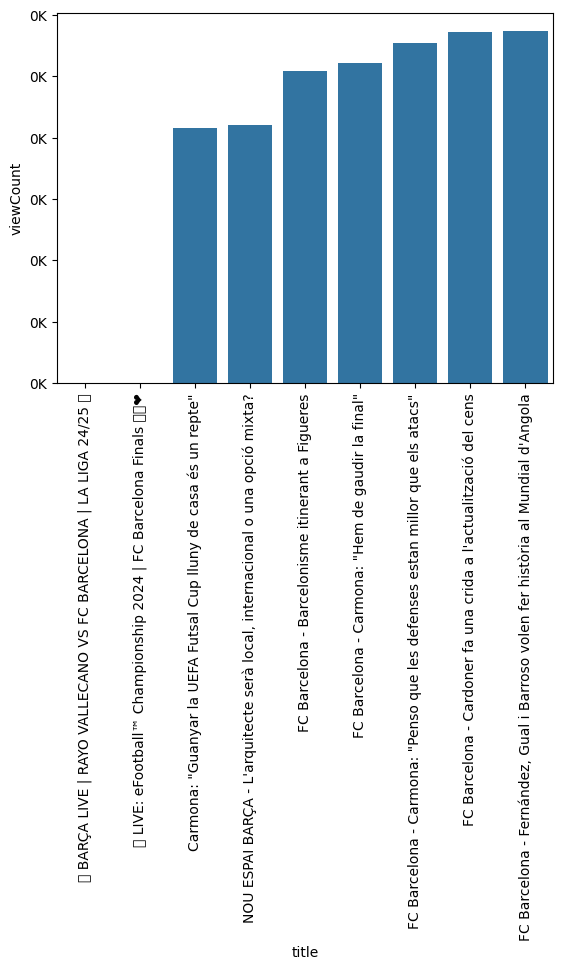

In [21]:
#create a bar plot for worst videos
ax = sns.barplot(x = 'title', y = 'viewCount', data = video_df.sort_values('viewCount', ascending=True)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

### Video Distribution Per Video ###

<Axes: xlabel='channelTitle', ylabel='viewCount'>

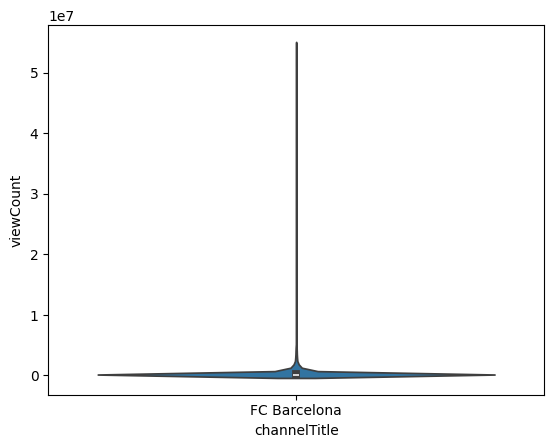

In [22]:
sns.violinplot(x='channelTitle', y='viewCount', data=video_df)

### Views vs. Likes & Comments ###

<Axes: xlabel='commentCount', ylabel='viewCount'>

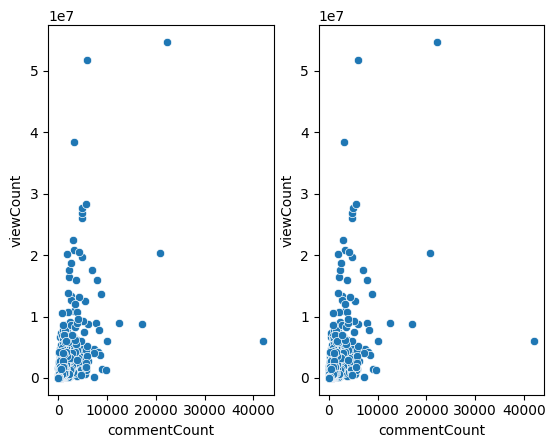

In [23]:
fig, ax = plt.subplots(1,2)
sns.scatterplot(data = video_df, x = 'commentCount', y = 'viewCount', ax = ax[0])
sns.scatterplot(data = video_df, x = 'commentCount', y = 'viewCount', ax = ax[1])

### Video Duration ###

<Axes: xlabel='durationSecs', ylabel='Count'>

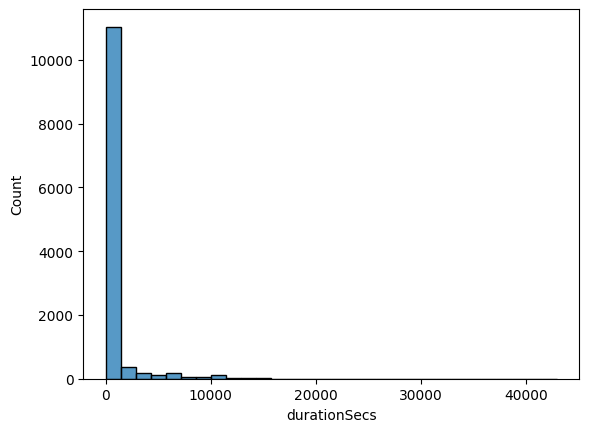

In [24]:
sns.histplot(data = video_df, x = 'durationSecs', bins=30)

### Wordcloud for video titles ###

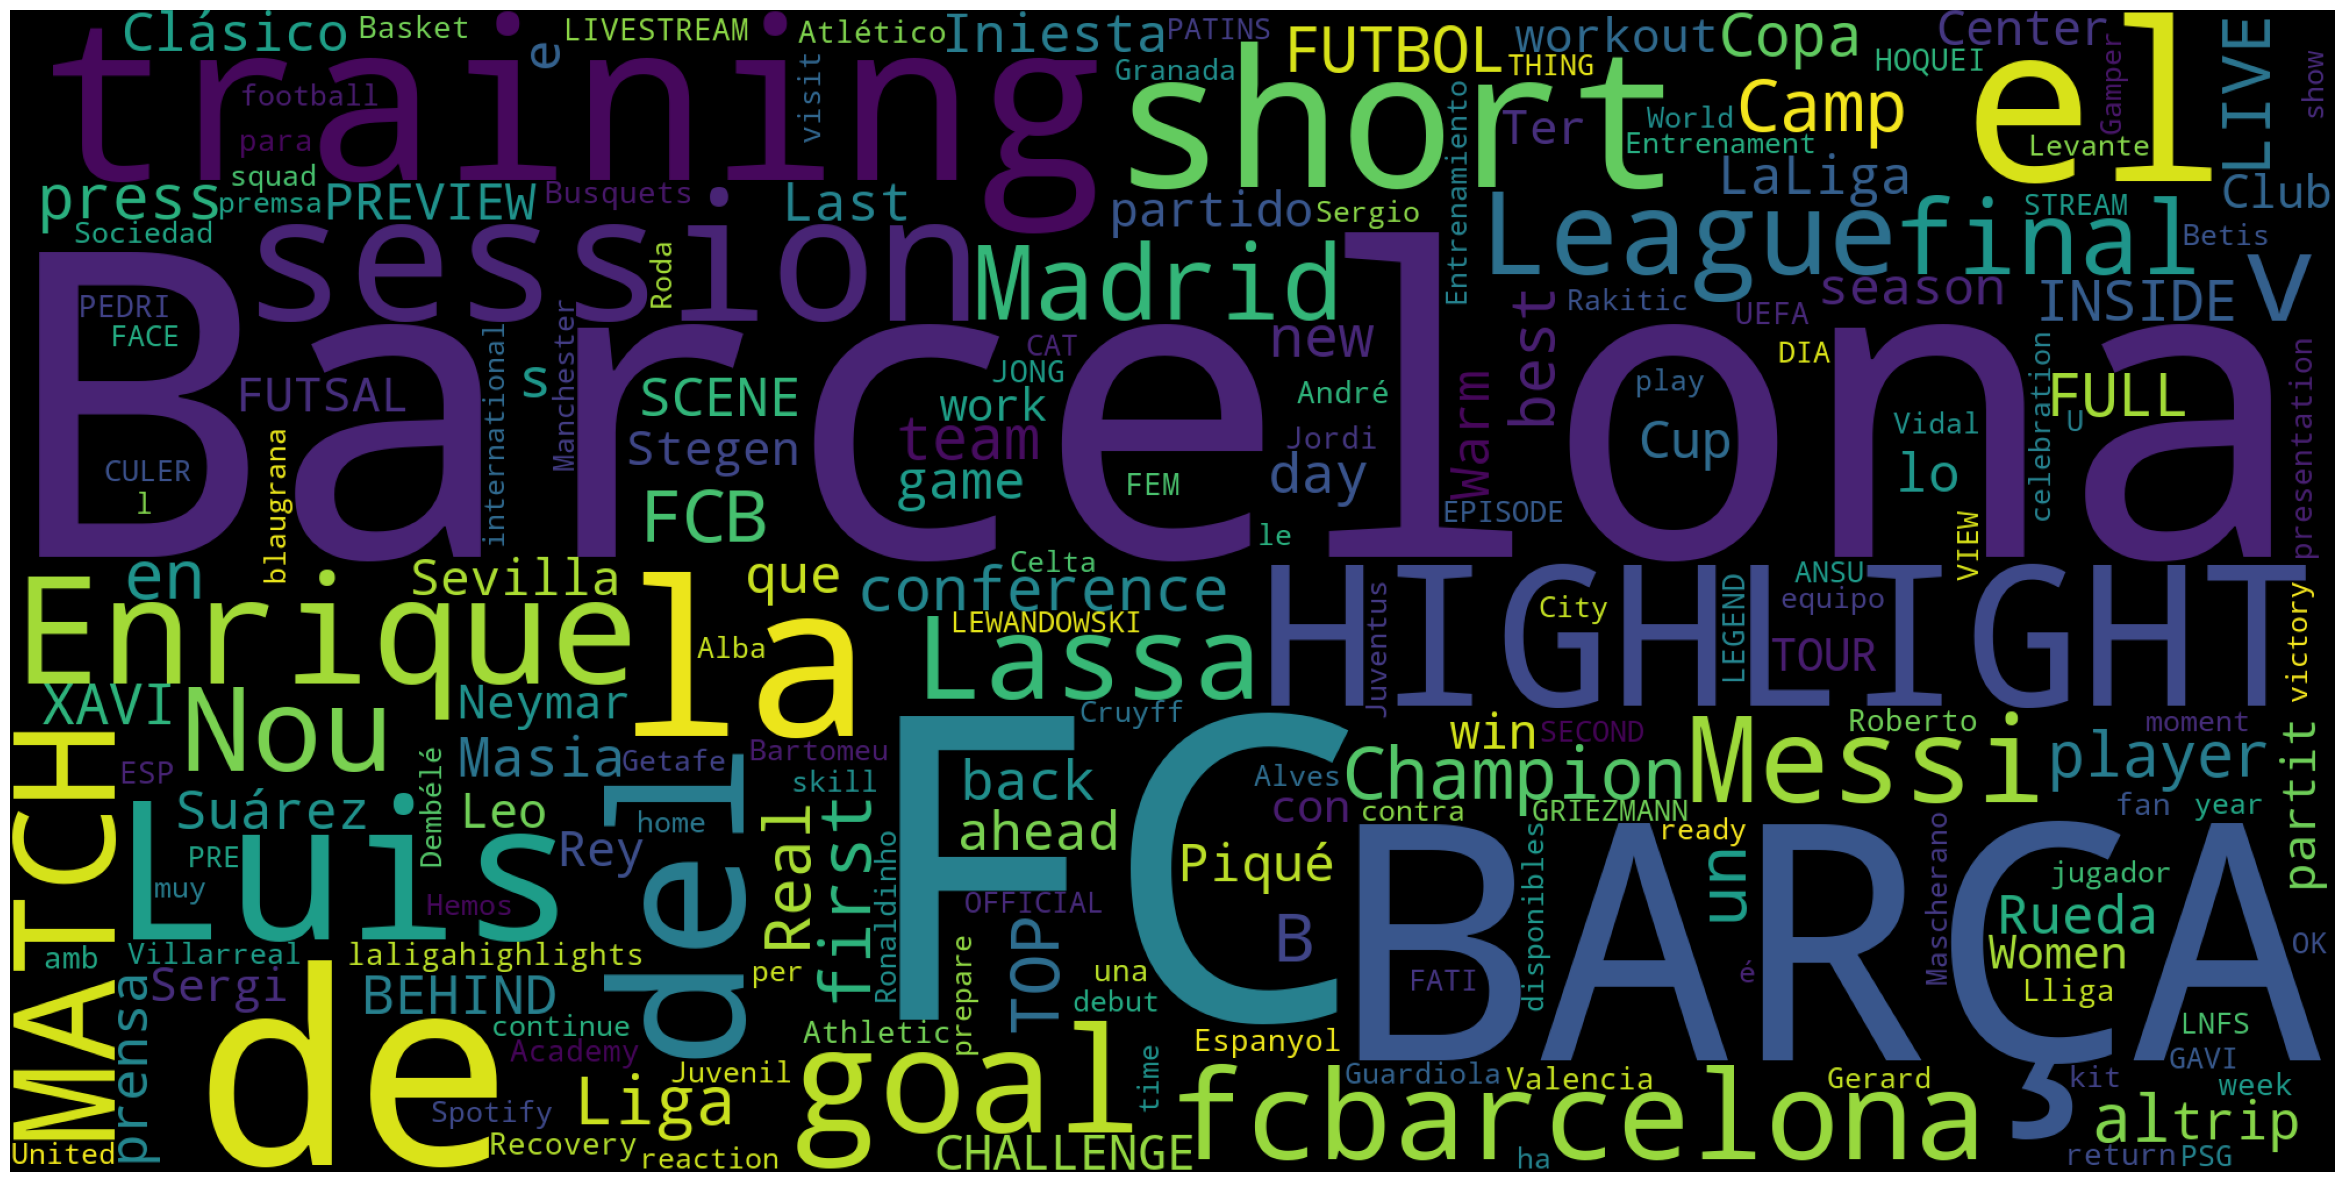

In [25]:
stop_words = set(stopwords.words('english'))
video_df['title_no_stopwords'] = video_df['title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in video_df['title_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words) 

def plot_cloud(wordcloud):
    plt.figure(figsize=(30, 20))
    plt.imshow(wordcloud) 
    plt.axis("off");

wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black', 
                      colormap='viridis', collocations=False).generate(all_words_str)
plot_cloud(wordcloud)

### Uploading schedule ###

Text(0, 0.5, 'Videos Uploaded')

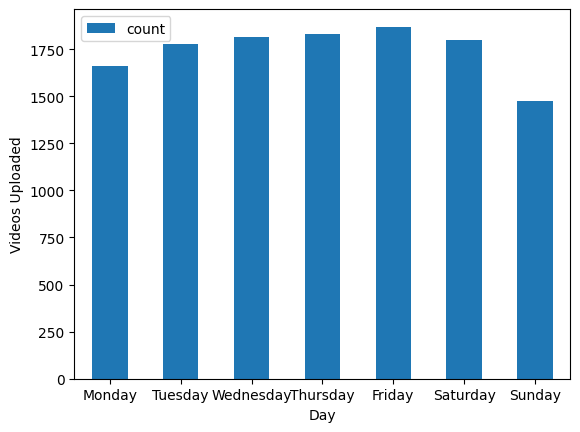

In [26]:
# create a barplot (which days in the week are most videos uploaded)
day_df = pd.DataFrame(video_df['publishDayName'].value_counts())
weekdays = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_df = day_df.reindex(weekdays)
ax = day_df.plot.bar(rot=0)
ax.set_xlabel('Day')
ax.set_ylabel('Videos Uploaded')